In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os
import datetime


import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.read())
f.close() 

In [3]:
path_to_rain_gauge_data = '../reference/'
area_path='../dataset/downloads/files/areas.yaml'
area_def = load_area(area_path, 'full_disk')

def get_gauge_locations():
    locs = pd.read_pickle(os.path.join(path_to_rain_gauge_data,'rain_gauge_locs.pckl'))
    colrows = []
    for lon, lat in zip(locs['lon'], locs['lat']):
        col, row = area_def.lonlat2colrow(lon, lat) #columns and rows in area_def grid coords 
        colrows.append((col, row))

    locs['cols'] = np.array(colrows)[:,0]
    locs['rows'] = np.array(colrows)[:,1]
    return(locs)


In [4]:
gauge_locs = get_gauge_locations()

/home/ingrid/anaconda/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [5]:
gauge_locs

,lon,lat,cols,rows
0,-56.437222,-30.368611,1777,2128
1,-46.027500,-7.455278,2100,1556
2,-45.372778,-1.661667,2122,1400
3,-57.526667,-11.280278,1818,1661
4,-43.864722,-8.443056,2145,1581
...,...,...,...,...
604,-43.184167,-13.416667,2145,1711
605,-41.106944,-20.104167,2154,1878
606,-50.425278,-16.945833,1973,1806
607,-49.274167,-8.259167,2025,1578


In [6]:
def preprocess_colrow(ds, col, row):
    region_corners_idx_low, __, __, region_corners_idy_low = ds.ind_extent
    
    values_list = []
    for k in list(ds.data_vars.keys()):
        newvals = np.stack([ds[k].isel(y=r, x=c).values 
                            for r,c in zip(row-region_corners_idy_low, col-region_corners_idx_low)])
        values_list.append((["location"], newvals))
    
    data_vars_dict = dict(zip(list(ds.data_vars.keys()), values_list))

    da = xr.Dataset(data_vars = data_vars_dict, coords=dict([("location", list(range(newvals.shape[0])))])) #("time", t)
 
    t = datetime.datetime.strptime(ds.attrs['end'], '%Y-%m-%d %H:%M:%S')
    print(t)
    da = da.assign_coords(dict(time=t))
    da = da.expand_dims('time').set_coords('time')

    return(da)

In [7]:
filepath = os.path.join(path_to_dataset, 'rain_gauge_preds', '1')
print(filepath)
c = gauge_locs.cols
r = gauge_locs.rows
combined = xr.open_mfdataset(filepath+'/*.nc', combine='by_coords',
                    concat_dim='time', preprocess=lambda ds: preprocess_colrow(ds, c, r))

/home/ingrid/Dendrite/UserAreas/Ingrid/rain_gauge_preds/1
2020-12-01 01:00:00
2020-12-01 02:00:00
2020-12-01 03:00:00
2020-12-01 04:00:00
2020-12-01 05:00:00
2020-12-01 06:00:00
2020-12-01 07:00:00
2020-12-01 08:00:00
2020-12-01 09:00:00
2020-12-01 10:00:00
2020-12-01 11:00:00
2020-12-01 12:00:00
2020-12-01 13:00:00
2020-12-01 14:00:00
2020-12-01 15:00:00
2020-12-01 16:00:00
2020-12-01 17:00:00
2020-12-01 18:00:00
2020-12-01 19:00:00
2020-12-01 20:00:00
2020-12-01 21:00:00
2020-12-01 22:00:00
2020-12-01 23:00:00


In [8]:
#combined.to_netcdf(os.path.join(path_to_dataset,'aggregated_rain_gauge_preds','pred_c'+str(1)+'.nc'))

In [9]:
real = pd.read_pickle(os.path.join(path_to_dataset,'real_rain_gauge_data', 'rain_gauges.pckl'))

391
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
739    0.0
740    0.0
741    0.0
742    0.0
743    0.0
Name: 391, Length: 744, dtype: float64


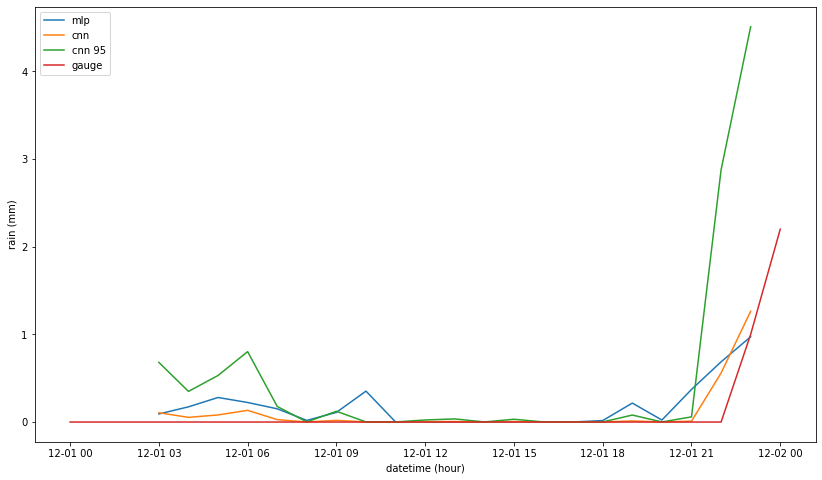

In [42]:
N=25
ind = 391 #308#4#np.random.randint(609)
print(ind)
v = combined.mlp_posterior_mean[:, ind].values
w = combined.xception_posterior_mean[:, ind].values
u = combined['xception_Q0.95'][:, ind].values

fig, ax = plt.subplots(figsize=(14,8))
plt.plot(combined.time, v, label='mlp')
plt.plot(combined.time, w, label='cnn')
plt.plot(combined.time, u, label='cnn 95')
print(real[str(ind)])
realt = [time.to_pydatetime() for time in real['timestamp']]
#print(combined.time)
#print(realt[:23])
plt.plot(realt[:N], real[str(ind)][:N], label='gauge')
ax.set_ylabel('rain (mm)')
ax.set_xlabel('datetime (hour)')
ax.legend()